<a href="https://colab.research.google.com/github/CleanPegasus/Behavioural-Cloning/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data

In [47]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import random
import ntpath
from imgaug import augmenters as iaa

Using TensorFlow backend.


## Data Visualisation

In [2]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
#pd.set_option['display.max_colwidth', -1]
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...   

                                                left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   

                                               right  steering  throttle  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   

   reverse     speed  
0      0.0  0.649786  
1      0.0  0.627942  
2      0.0  0.622910  
3      0.0  0.619162  
4      0.0  0.615438

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

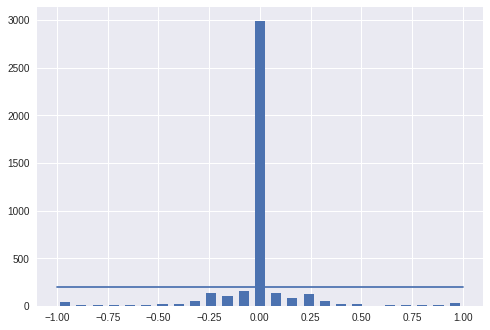

In [4]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed: 2790
remainind data:  1263


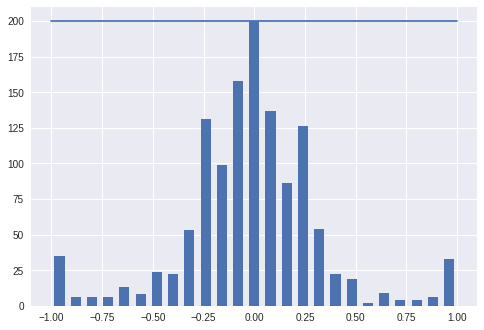

In [5]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
      
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remainind data: ', len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## Train Test Split

In [6]:
print(data.iloc[1])

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths, steering
  
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_44_342.jpg
left          left_2018_07_16_17_11_44_342.jpg
right        right_2018_07_16_17_11_44_342.jpg
steering                                     0
throttle                              0.382694
reverse                                      0
speed                                 0.946799
Name: 11, dtype: object


In [0]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)

Text(0.5,1,'Validation Set')

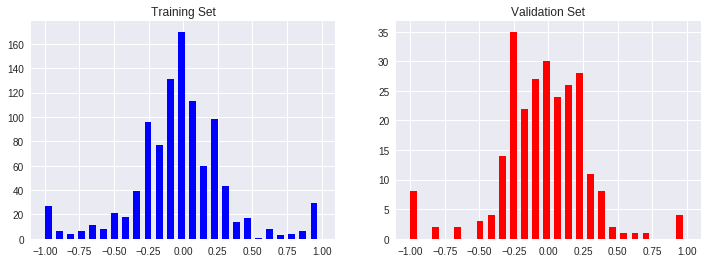

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axs[0].set_title('Training Set')
axs[1].hist(y_val, bins = num_bins, width = 0.05, color = 'red')
axs[1].set_title('Validation Set')

## Augmentation of Data

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

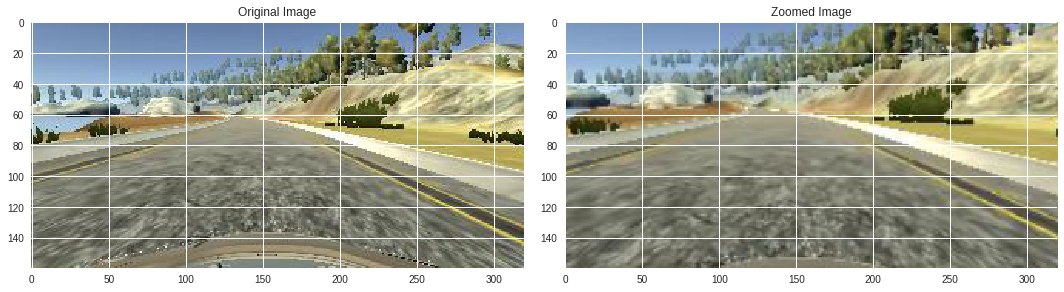

In [10]:
image = image_paths[100]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5,1,'Panned Image')

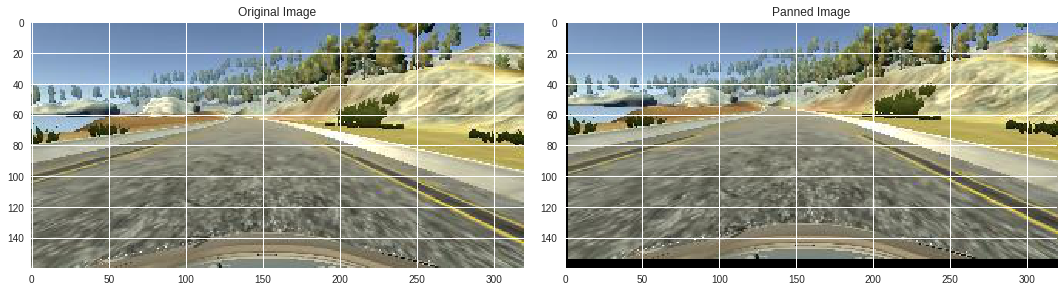

In [12]:
image = image_paths[100]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5,1,'Bright Image')

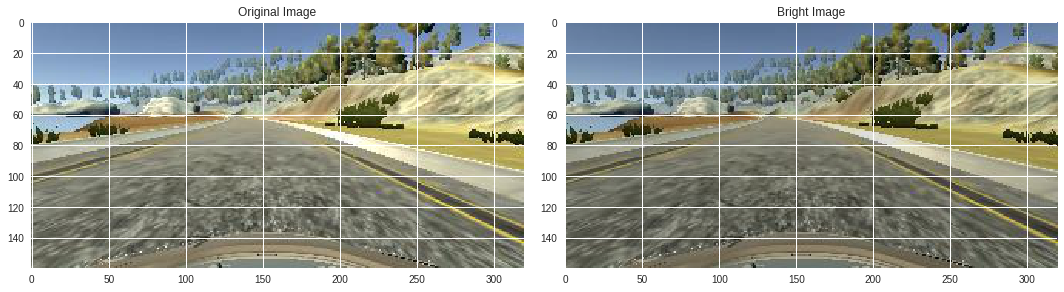

In [14]:
image = image_paths[100]
original_image = mpimg.imread(image)
bright_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(bright_image)
axs[1].set_title('Bright Image')

In [0]:
def flip_image(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5,1,'Flipped Image Steering Angle 0.15')

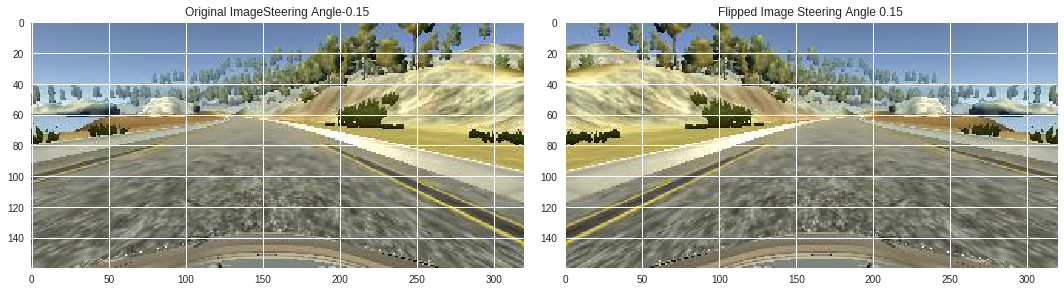

In [19]:
image = image_paths[100]
steering_angle = steerings[100]
original_image = mpimg.imread(image)
flipped_image, steering_flipped = flip_image(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image' + 'Steering Angle' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image ' + 'Steering Angle ' + str(steering_flipped))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
   
  if np.random.rand() < 0.5:
    image = zoom(image)
    
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
    
  if np.random.rand() < 0.5:
    image, steering_angle = flip_image(image, steering_angle)
    
  return image, steering_angle

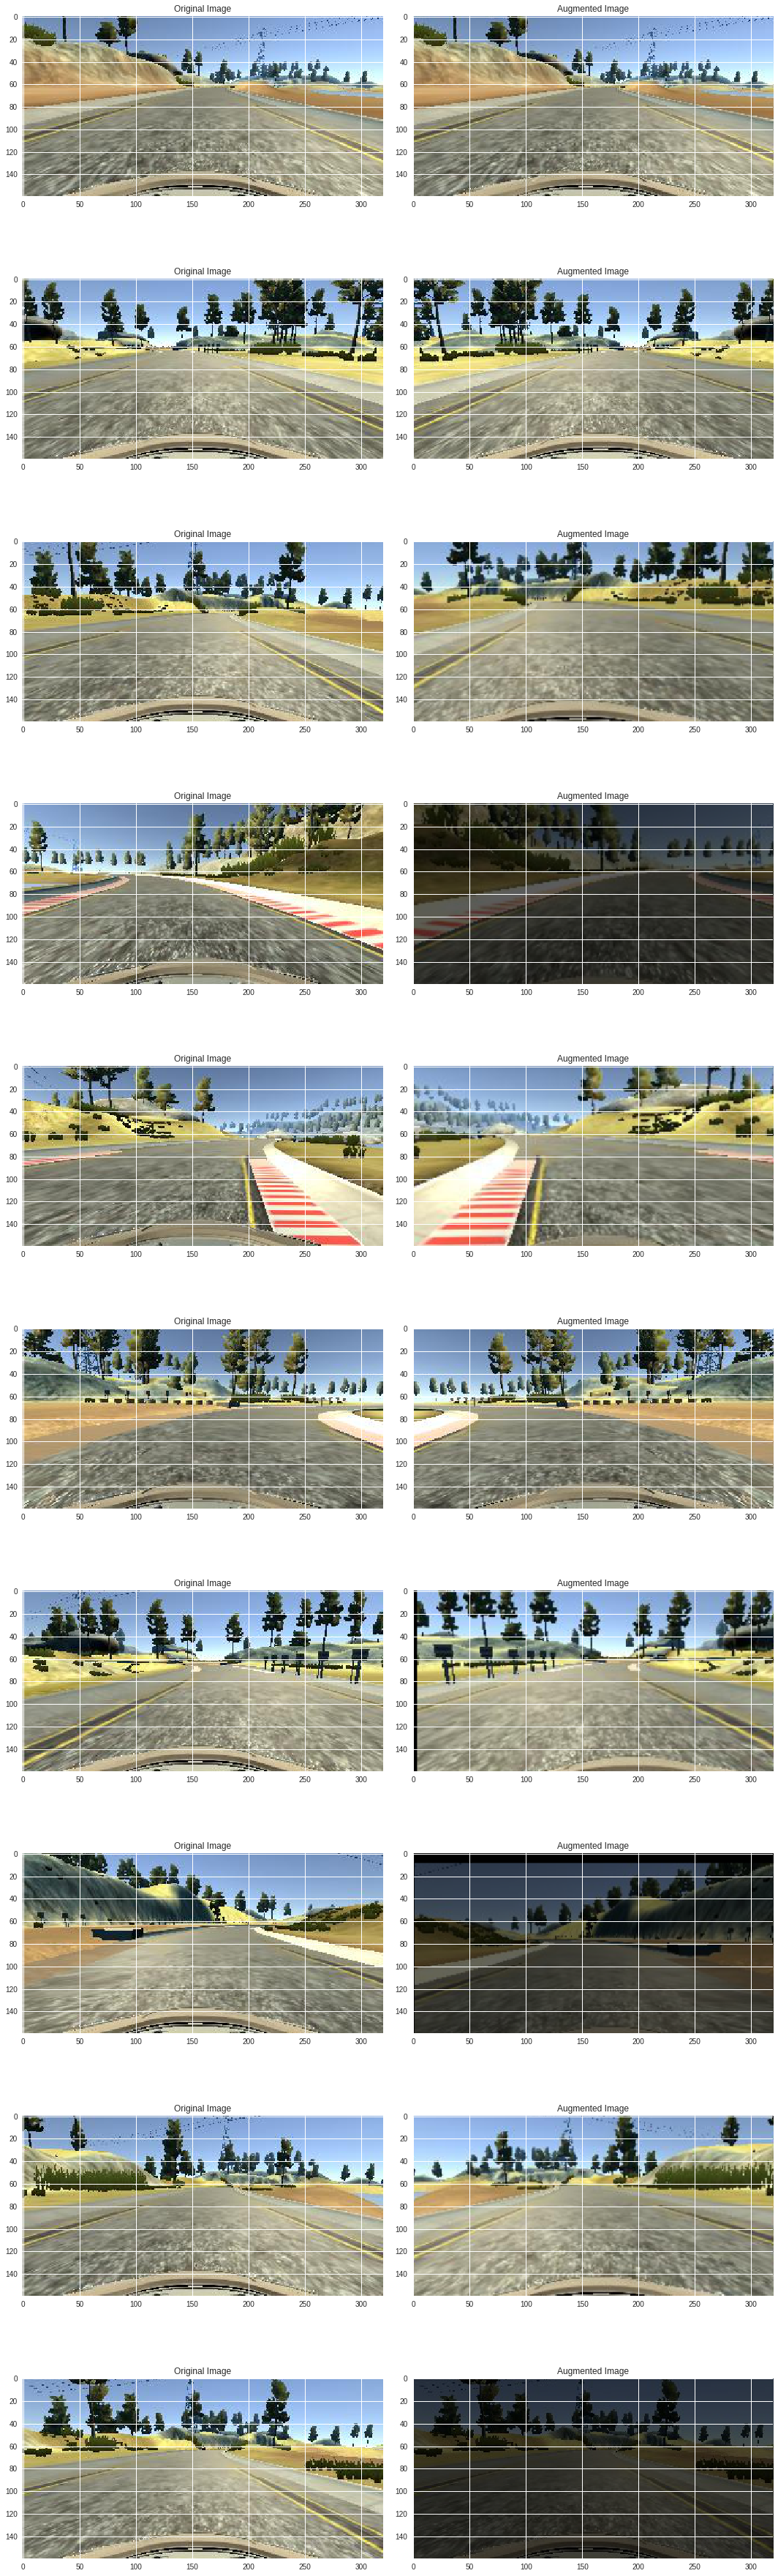

In [27]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize = [15, 50])
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135 , : , : ,]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5,1,'Preprocessed Image')

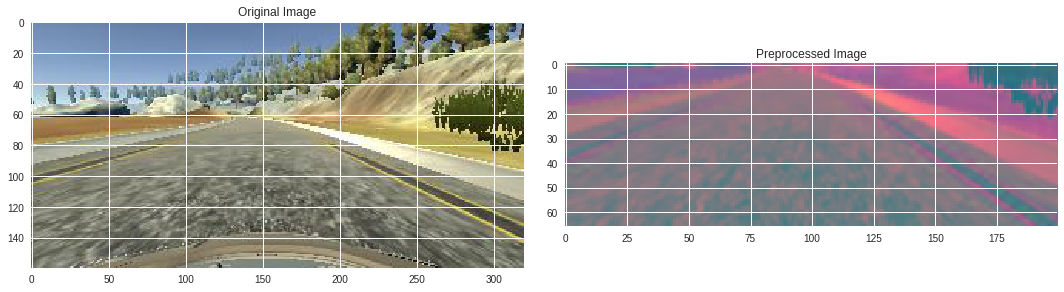

In [11]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(-0.5, 199.5, 65.5, -0.5)

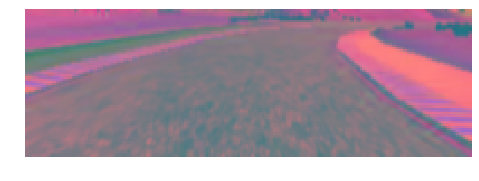

In [0]:
plt.imshow(X_train[10])
plt.axis('off')

## Nvidia Model

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model
  

In [0]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
__________

In [0]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), batch_size = 100, verbose = 1, shuffle = 1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 2s 2ms/step - loss: 0.9870 - val_loss: 0.1108
Epoch 2/30
1010/1010 [==============================] - 1s 731us/step - loss: 0.3063 - val_loss: 0.1200
Epoch 3/30
1010/1010 [==============================] - 1s 701us/step - loss: 0.1883 - val_loss: 0.1088
Epoch 4/30
1010/1010 [==============================] - 1s 689us/step - loss: 0.1473 - val_loss: 0.1088
Epoch 5/30
1010/1010 [==============================] - 1s 684us/step - loss: 0.1337 - val_loss: 0.1025
Epoch 6/30
1010/1010 [==============================] - 1s 682us/step - loss: 0.1293 - val_loss: 0.1050
Epoch 7/30
1010/1010 [==============================] - 1s 680us/step - loss: 0.1308 - val_loss: 0.0985
Epoch 8/30
1010/1010 [==============================] - 1s 695us/step - loss: 0.1263 - val_loss: 0.0949
Epoch 9/30
1010/1010 [==============================] - 1s 678us/step - loss: 0.1146 - val_loss: 0.0905
Epoch 10/30
1010/10

Text(0.5,0,'epoch')

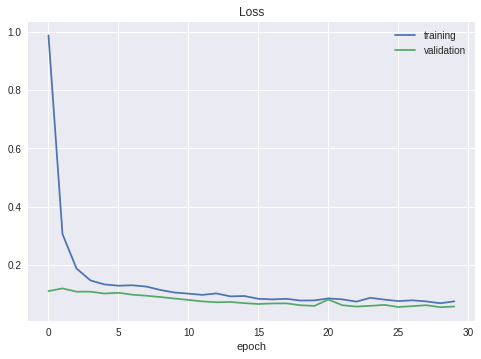

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')